<a href="https://colab.research.google.com/github/gladcolor/county_network/blob/master/county_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data

## Install packages

In [76]:
! pip install plotly
! pip install plotly-geo
! pip install geopandas
! pip install pyshp
! pip install shapely
! pip install wget

## Import packages

In [2]:
import pandas as pd
import os
import sys
import numpy as np
import ast

from urllib.request import urlopen
from zipfile import ZipFile


from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import MonthLocator, DateFormatter
import wget
import geopandas as gpd


## Download files

In [3]:
shapefile_url = r'https://github.com/gladcolor/county_network/raw/master/us_counties.zip'
wget.download(shapefile_url)
downloaded_file = os.path.basename(shapefile_url)

## Generate neighors and centroids

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




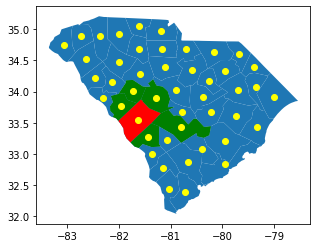

In [77]:
from matplotlib import pyplot as plt

US_gdf = gpd.read_file(f'zip://{downloaded_file}')
SC_gdf = US_gdf[US_gdf["STATE"] == '45']



def find_neighbors(row, gdf):
    neighbor_idx = gdf[gdf.geometry.touches(row['geometry'])].index   
    return neighbor_idx

SC_gdf['centroid'] = SC_gdf['geometry'].centroid
SC_gdf['neighbor_idx'] = SC_gdf.apply(find_neighbors, axis=1, args=(SC_gdf,))

# test results
test_id =21
f, ax = plt.subplots()
SC_gdf.plot(ax=ax)
SC_gdf.iloc[test_id:test_id + 1].plot(ax=ax, color='red')
neighbor_idx = SC_gdf.iloc[test_id]['neighbor_idx']
SC_gdf.loc[neighbor_idx].plot(ax=ax, color='green')
SC_gdf['centroid'].plot(ax=ax, color='yellow')

In [88]:
print("Neighbors of the first county:")
SC_gdf.loc[SC_gdf.iloc[0]['neighbor_idx']]

Neighbors of the first county:


,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,FIPS,fips_1,average_20,complete_2,average_48,complete_4,average_50,complete_5,average_75,complete_7,geometry,centroid,neighbor_idx
458,0500000US45009,45,009,Bamberg,County,393.370,US45009,US45009,2,3,9,4,9,0,23,5,"POLYGON Z ((-81.22011 33.43949 0.00000, -80.94...",POINT (-81.06173 33.22034),"Int64Index([457, 478, 480, 2563, 2642], dtype=..."
478,0500000US45049,45,049,Hampton,County,559.896,US45049,US45049,2,3,9,4,9,0,23,5,"POLYGON Z ((-80.82631 32.70432 0.00000, -80.83...",POINT (-81.14126 32.77500),"Int64Index([457, 458, 479, 2563, 2643], dtype=..."
2563,0500000US45029,45,029,Colleton,County,1056.491,US45029,US45029,4,7,10,26,10,26,50,12,"POLYGON Z ((-80.47691 32.48539 0.00000, -80.55...",POINT (-80.66791 32.86929),"Int64Index([457, 458, 478, 480, 1013, 2643, 27..."
2642,0500000US45011,45,011,Barnwell,County,548.393,US45011,US45011,2,3,9,4,9,0,23,5,"POLYGON Z ((-81.77225 33.18012 0.00000, -81.75...",POINT (-81.43665 33.26573),"Int64Index([457, 458, 480, 1527], dtype='int64')"


## Generate edges

In [91]:
edges = []
def get_edges(row, gdf, edges):
    neighbors = gdf.loc[row['neighbor_idx']]
    from_x = row['centroid'].x
    from_y = row['centroid'].y
   
    for idx, n in neighbors.iterrows():
        to_x = n['centroid'].x
        to_y = n['centroid'].y
        # print(from_x, from_y, to_x, to_y)
        edges.append((from_x, from_y, to_x, to_y))

SC_gdf.apply(get_edges, axis=1, args=(SC_gdf, edges))

edges = np.array(edges)
edge_df = pd.DataFrame(edges, columns = ['start_lon','start_lat','end_lon', 'end_lat'])
edge_df

,start_lon,start_lat,end_lon,end_lat
0,-81.354093,32.990295,-81.061734,33.220337
1,-81.354093,32.990295,-81.141258,32.774995
2,-81.354093,32.990295,-80.667914,32.869286
3,-81.354093,32.990295,-81.436647,33.265733
4,-81.061734,33.220337,-81.354093,32.990295
...,...,...,...,...
221,-79.952439,33.198262,-80.801101,33.439079
222,-79.952439,33.198262,-80.402646,33.077628
223,-79.952439,33.198262,-79.729776,33.614825
224,-79.952439,33.198262,-79.332293,33.431003


# Draw figure

## Draw all edges

In [102]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import plotly
import plotly.figure_factory as ff
import numpy as np



fig = go.Figure(go.Scattergeo())






# draw edges
lons = []
lats = []
import numpy as np
lons = np.empty(3 * len(edge_df))
lons[::3] = edge_df['start_lon']
lons[1::3] = edge_df['end_lon']
lons[2::3] = None
lats = np.empty(3 * len(edge_df))
lats[::3] = edge_df['start_lat']
lats[1::3] = edge_df['end_lat']
lats[2::3] = None

fig.add_trace(
    go.Scattergeo(
        locationmode = 'USA-states',
        lon = lons,
        lat = lats,
        mode = 'lines',
        line = dict(width = 2,color = 'red'),
        opacity = 0.5
    )
)

# draw county boundaries
for idx, row in SC_gdf.iterrows():
    polygon_lons = row['geometry'].exterior.coords.xy[0]
    polygon_lats = row['geometry'].exterior.coords.xy[1]
    fig.add_trace(
        go.Scattergeo(
            # locationmode = 'USA-states',
            lon = np.array(polygon_lons),
            lat = np.array(polygon_lats),
            mode = 'lines',
            line = dict(width = 1,color = 'black'),
            opacity = 0.5
        )
    )

# draw centroids
fig.add_trace(go.Scattergeo(
    
    lon = SC_gdf['centroid'].x,
    lat = SC_gdf['centroid'].y,
    hoverinfo = 'text',
    text = SC_gdf['NAME'],
    mode = 'markers',
    marker = dict(
        size = 6,
        color = 'rgba(255, 255, 255, 100)',
        line = dict(
            width = 1,
            color = 'rgba(0, 0, 0, 50)'
        )
    )))

# show figure
fig.update_layout(
    title_text = "South Carolina Counties' Neighbor Network",
    geo = go.layout.Geo(        
        scope="north america",
        projection_type = 'azimuthal equal area',
        showland = False,
        landcolor = 'rgba(243, 243, 243, 0)',
        countrycolor = 'rgba(204, 204, 204, 0)',
        countrywidth=0,
        coastlinewidth=0,

    ),
    height=1000,
    width=1600,
)

fig.update_geos(center_lon=-81,
                center_lat=33,                
                )

fig.show()

## Draw some edges

Change the ```sample_fraction``` to [0, 1] to show less edges.

In [103]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import plotly
import plotly.figure_factory as ff
import numpy as np



fig = go.Figure(go.Scattergeo())

sample_fraction = 0.5

sampled_edge_df = edge_df.sample(frac=sample_fraction)

# draw edges
lons = []
lats = []
import numpy as np
lons = np.empty(3 * len(sampled_edge_df))
lons[::3] = sampled_edge_df['start_lon']
lons[1::3] = sampled_edge_df['end_lon']
lons[2::3] = None
lats = np.empty(3 * len(sampled_edge_df))
lats[::3] = sampled_edge_df['start_lat']
lats[1::3] = sampled_edge_df['end_lat']
lats[2::3] = None

fig.add_trace(
    go.Scattergeo(
        locationmode = 'USA-states',
        lon = lons,
        lat = lats,
        mode = 'lines',
        line = dict(width = 2,color = 'red'),
        opacity = 0.5
    )
)

# draw county boundaries
for idx, row in SC_gdf.iterrows():
    polygon_lons = row['geometry'].exterior.coords.xy[0]
    polygon_lats = row['geometry'].exterior.coords.xy[1]
    fig.add_trace(
        go.Scattergeo(
            # locationmode = 'USA-states',
            lon = np.array(polygon_lons),
            lat = np.array(polygon_lats),
            mode = 'lines',
            line = dict(width = 1,color = 'black'),
            opacity = 0.5
        )
    )

# draw centroids
fig.add_trace(go.Scattergeo(
    
    lon = SC_gdf['centroid'].x,
    lat = SC_gdf['centroid'].y,
    hoverinfo = 'text',
    text = SC_gdf['NAME'],
    mode = 'markers',
    marker = dict(
        size = 6,
        color = 'rgba(255, 255, 255, 100)',
        line = dict(
            width = 1,
            color = 'rgba(0, 0, 0, 50)'
        )
    )))

# show figure
fig.update_layout(
    title_text = "South Carolina Counties' Neighbor Network",
    geo = go.layout.Geo(        
        scope="north america",
        projection_type = 'azimuthal equal area',
        showland = False,
        landcolor = 'rgba(243, 243, 243, 0)',
        countrycolor = 'rgba(204, 204, 204, 0)',
        countrywidth=0,
        coastlinewidth=0,

    ),
    height=1000,
    width=1600,
)

fig.update_geos(center_lon=-81,
                center_lat=33,                
                )

fig.show()